### Paint Method Comparison

Jenny Kim, Phil Marshall
The OM10 mock lensed quasar catalog `qso_mock.fits` contains estimates of the lens galaxy $i$-band magnitudes, based on a simple Faber-Jackson scaling implemented by Phil Marshall. With the `lenspop` library we can compute synthetic magnitudes in any filter. In this notebook we will look at the differences in the distributions of the 1) redshift, 2) $i$-band magnitude, 3) $g-r$ magnitude, 4) $r-i$ magnitude, and 5) $i-z$ magnitude by :

- comparing the magnitude of colored lensed with SDSS LRGs
- comparing the magnitude of colored lensed with 56 candidate galaxy-scale lenses that was taken with Canada-France-Hawaii Telescope (CFHT)
- comparing the magnitude of colored quasars with known SDSS Quasars


### Requirements
`om10`, `qso_mock.fits`, and `om10`'s dependencies:

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os, matplotlib, numpy as np
import om10, corner
from om10 import plotting
from __future__ import division
from astropy.table import Table
from astropy.io import ascii
import pandas as pd
sns.set()

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first have to load the om10 catalog and select 200 random lenses. Using the `paint` method, we color those lenses synthetically.

In [17]:
%%capture
db = om10.DB(catalog='/Users/Jenny/Desktop/om10fork/om10/data/qso_mock.fits')
db.select_random(Nlens=200)
db.paint(synthetic=True)

### 1 Comparing the magnitude with SDSS LRGs

We will overlap the colored lenses with the SDSS LRGs on the cornerplot. The data is save in `../data/SDSS_LRGs.txt`. The file has these following columns : `ra  dec  z  mag_u  mag_g  mag_r  mag_i  mag_z`.

In [18]:
%%capture
table = np.loadtxt('../data/SDSS_LRGs.txt')
zReal = table[:,2]
iReal = table[:,6]
grReal = table[:,4]-table[:,5]
riReal = table[:,5]-table[:,6]
izReal = table[:,6]-table[:,7]

Before putting all of the real and mock lenses directly onto the cornerplot, we need to weight the mocked lenses with respect to the parent population. The parent population would be gaussian distributed, and the mean would be given by $np.mean(z)$ and the standard deviation would be given by $np.std(z)$.

The weight could first be calculated by using this formula:

$$\frac { P(redshift) }{ Q(redshift) } $$

where P(redshift) is a y-value of redshift in the parent normal distribution and Q(redshift) is a y-value of redshift in the mock, colored lenses. 

In addition to this, we can use rejection sampling method to make the distribution more like its gaussian population distribution.

Reweighting algorithm is implemented in `gaussian_reweight`.

In [19]:
%%capture
db.gaussian_reweight(np.mean(zReal), np.std(zReal))
# calculate the color index for g-r, r-i, and i-z
gr = db.sample['g_SDSS_lens'] - db.sample['r_SDSS_lens']
ri = db.sample['r_SDSS_lens'] - db.sample['i_SDSS_lens']
iz = db.sample['i_SDSS_lens'] - db.sample['z_SDSS_lens']

Then, we draw the cornerplot with the synthetically colored OM10 lenses and save to the argument `fig1`.  Then, we will overlap the synthetically colored samples with the original data. Ideally, the distributions of the data should look similar, and the blue contours and the red contours should have significant overlap.

In [20]:
matplotlib.rc('text', usetex=False)
# save the syntheticall colored OM10 lenses' cornerplot to fig1
data = Table({'i_SDSS': db.sample['i_SDSS_lens'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

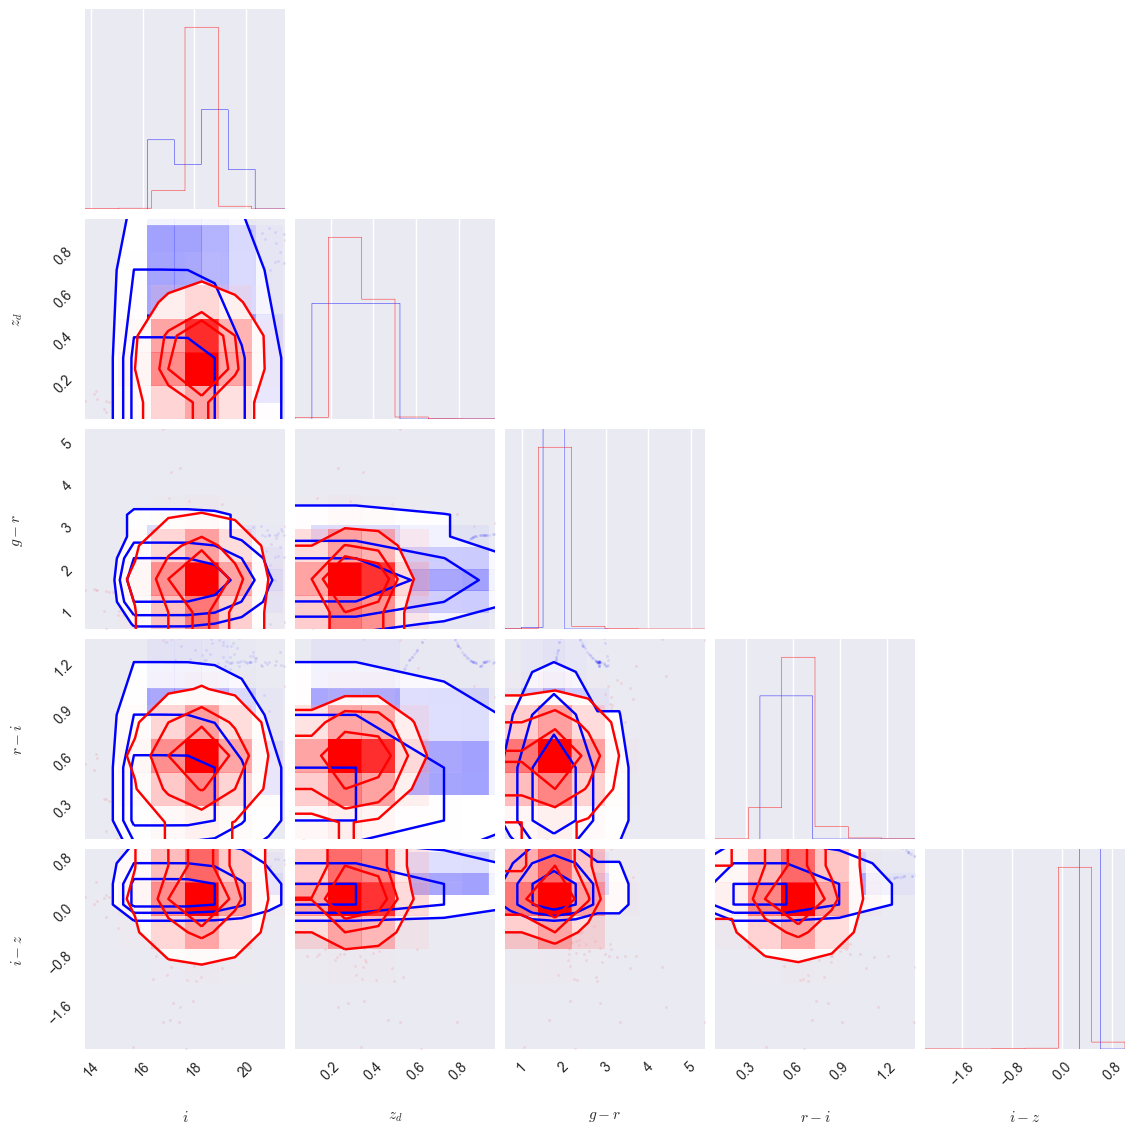

In [21]:
#overlap fig1 with the real distribution
data = Table({'i_SDSS': iReal, 'ZLENS': zReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True), hist2d_kwarge=dict(alpha=0.5))

### 2 Comparing the Color of Lenses using data from Sonnenfeild et al's paper

Jenny Kim, Phil Marshall

[This paper(Sonnenfeild et al.)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/97/meta#apj485108t5) and [this paper(Sonnenfeild et al.)](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/98/meta) contain the information of 56 candidate galaxy-scale lenses that was taken with Canada-France-Hawaii Telescope (CFHT). The CFHT magnitudes and SDSS magnitudes are different by $~0.05 mag$. Thus, for the sake of simple calculation, we ignored the differences in this notebook while drawing the cornerplot.

The first textfile `../data/1.txt` and the second textfile `../data/2.txt` is from the [third paper of Sonnenfeild et al](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/97/meta#apj485108t5). The third textfile `../data/3.txt` is from the [fourth paper of Sonnenfeild at al](http://iopscience.iop.org/article/10.1088/0004-637X/777/2/98/meta). `../data/1.txt` contains U, G, R, I, Z bands magnitudes, `../data/2.txt` constains redshifts, and `../data/3.txt` contains velocity dispersions. All the files contain LensName, which we used to match the data in different textfiles. The second cell below merges all the information needed.

In [22]:
III_a = np.genfromtxt('../data/SonnenfeildTable1.txt', dtype=str, usecols = (0, 4, 5, 6, 7, 8), invalid_raise=False, missing_values='xxx', usemask=False)
III_b = np.genfromtxt('../data/SonnenfeildTable2.txt', dtype=str, usecols = (0, 1), invalid_raise=False, missing_values='xxx')
IV = np.genfromtxt('../data/SonnenfeildTable3.txt', dtype=str, usecols = (0, 11), invalid_raise=False, missing_values='xxx')

/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: ConversionWarning: Some errors were detected !
    Line #7 (got 1 columns instead of 2)
    Line #36 (got 1 columns instead of 2)
    Line #41 (got 1 columns instead of 2)
    Line #45 (got 1 columns instead of 2)
  from ipykernel import kernelapp as app
/Users/Jenny/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: ConversionWarning: Some errors were detected !
    Line #12 (got 11 columns instead of 2)
    Line #41 (got 11 columns instead of 2)
    Line #49 (got 11 columns instead of 2)
    Line #66 (got 11 columns instead of 2)
    Line #71 (got 11 columns instead of 2)
  app.launch_new_instance()


In [23]:
name = np.array([])
redshiftReal = np.array([])
iReal = np.array([])
grReal = np.array([])
riReal = np.array([])
izReal = np.array([])
for (lensName, aIndex) in zip(III_a[:,0], range(len(III_a))):
    if lensName in III_b[:,0]:
        bIndex = np.argwhere(III_b[:,0]==lensName)[0][0]
        if lensName in IV[:,0]:
            VIndex = np.argwhere(IV[:,0]==lensName)[0][0]
            # the redshift sometimes has some problem, so we should handle those problems
            if(IV[VIndex][1].isdigit()):
                name = np.append(name, lensName)
                redshiftReal = np.append(redshiftReal, float(III_b[bIndex][1]))
                iReal = np.append(iReal, float(III_a[aIndex][4]))
                grReal = np.append(grReal, float(III_a[aIndex][2]) - float(III_a[aIndex][3]))
                riReal = np.append(riReal, float(III_a[aIndex][3]) - float(III_a[aIndex][4]))
                izReal = np.append(izReal, float(III_a[aIndex][4]) - float(III_a[aIndex][5]))
#convert every numpy array to list - if not, OM10.plot_sample throws an error
redshift = np.array(redshiftReal.tolist())
iReal = np.array(iReal.tolist())
grReal = np.array(grReal.tolist())
riReal = np.array(riReal.tolist())
izReal = np.array(izReal.tolist())
from astropy.table import Table
data = Table({'MAGI': iReal, 'ZLENS': redshiftReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['MAGI', 'ZLENS', 'GR', 'RI', 'IZ'])

We only have around 35 valid, real lenses to use to weight the mock lenses. This is not an ideal situation, but still, let's plot the synthetically colored lenses onto the cornerplot after reweighting the mock lenses.

We will overlap the synthetically colored samples with this original data. Ideally, the distributions of the data should be similar, and the blue contours and the red contours should have significant overlap.

In [24]:
%%capture
db.gaussian_reweight(np.mean(redshift), np.std(redshift))
matplotlib.rc('text', usetex=False)
# GR Color index
gr = db.sample['g_SDSS_lens'] - db.sample['r_SDSS_lens']
ri = db.sample['r_SDSS_lens'] - db.sample['i_SDSS_lens']
iz = db.sample['i_SDSS_lens'] - db.sample['z_SDSS_lens']
data = Table({'i_SDSS': db.sample['i_SDSS_lens'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))

fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

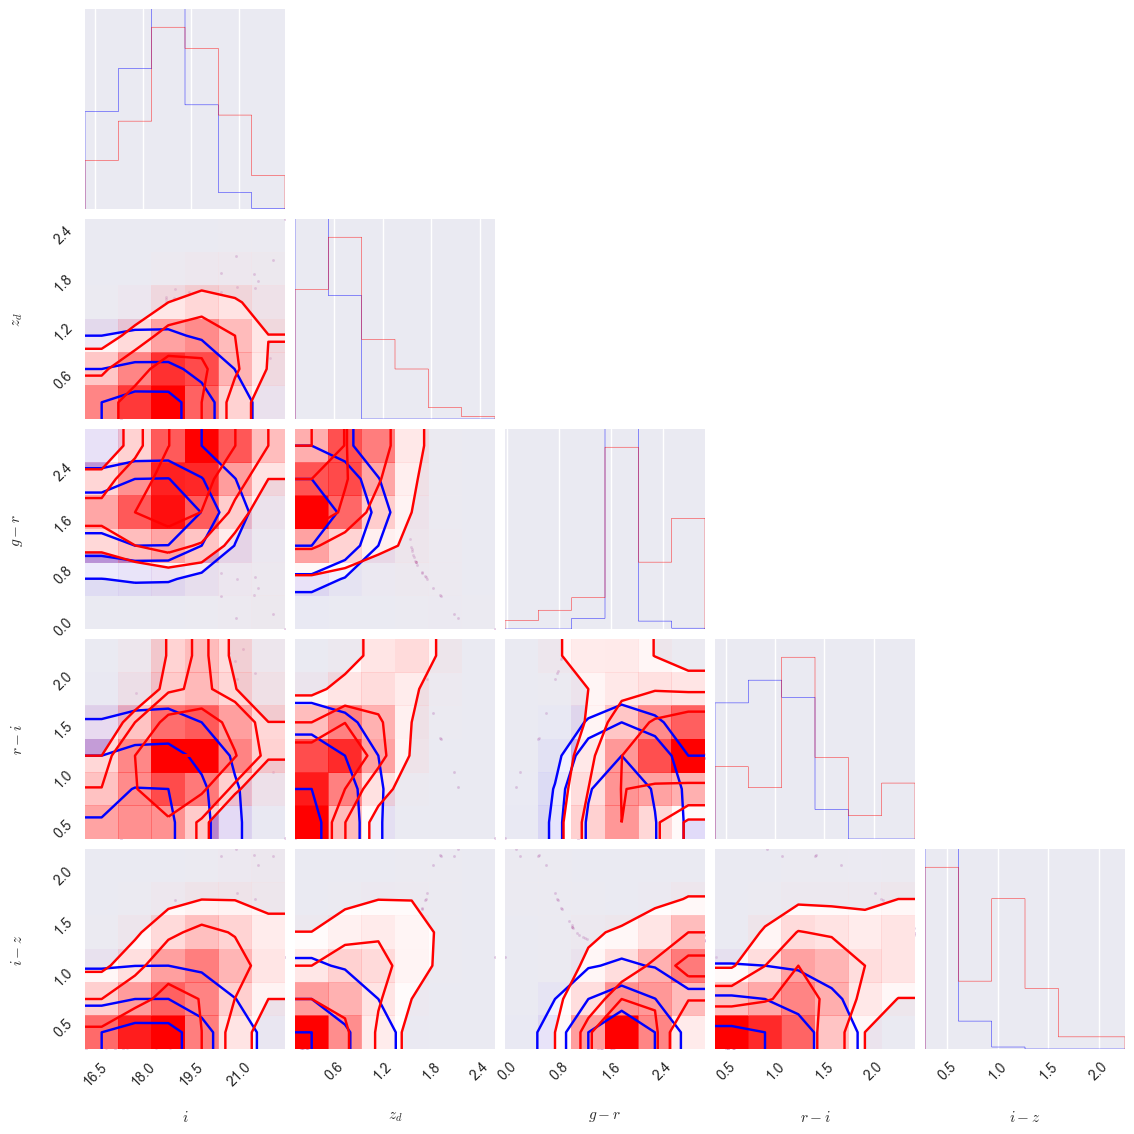

In [25]:
%matplotlib inline
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.0, fig=fig1, hist_kwargs=dict(normed=True))

### Comparing the Color of Quasars

Jenny Kim, Phil Marshall

[This file](https://github.com/KIPAC/StatisticalMethods/blob/master/examples/SDSScatalog/data/qso10000.csv) contains SDSS quasar magnitudes and redshifts. With the lenspop library, we could compute the synthetic magnitudes in g, r, i, and z filter of the quasar samples in the file. We will compare the synthetically colored OM10 lenses with this data.

In [26]:
# Read the data
pd.set_option('display.max_columns', None)
qsos = pd.read_csv("../../StatisticalMethods/examples/SDSScatalog/data/qso10000.csv",index_col=0)
# Clean out extreme colors and bad magnitudes:
qsos = qsos[(qsos["dered_r"] > -9999) & (qsos["g_r_color"] > -10) & (qsos["g_r_color"] < 10) & (qsos["mag_i"]<23.6)]
qso = qsos.as_matrix()

matplotlib.rc('text', usetex=False)
zReal = qsos["spec_z"].as_matrix()

db.gaussian_reweight(np.mean(zReal), np.std(zReal))
matplotlib.rc('text', usetex=False)
# calculate the color index for g-r, r-i, and i-z
gr = db.sample['g_SDSS_quasar'] - db.sample['r_SDSS_quasar']
ri = db.sample['r_SDSS_quasar'] - db.sample['i_SDSS_quasar']
iz = db.sample['i_SDSS_quasar'] - db.sample['z_SDSS_quasar']
data = Table({'i_SDSS': db.sample['i_SDSS_quasar'], 'ZLENS': db.sample['ZLENS'], 'GR': gr, 'RI': ri, 'IZ': iz}, names=['i_SDSS', 'ZLENS', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('i_SDSS','ZLENS', 'GR', 'RI', 'IZ'))
fig1 = corner.corner(features, labels=labels, color='blue', weights=db.sample['weight'], smooth=1.3,  hist_kwargs=dict(normed=True, alpha=1))

In [27]:
iReal = qsos["mag_i"].as_matrix()
grReal = qsos["g_r_color"].as_matrix()
riReal = qsos["r_i_color"].as_matrix()
izReal = qsos["i_z_color"].as_matrix()

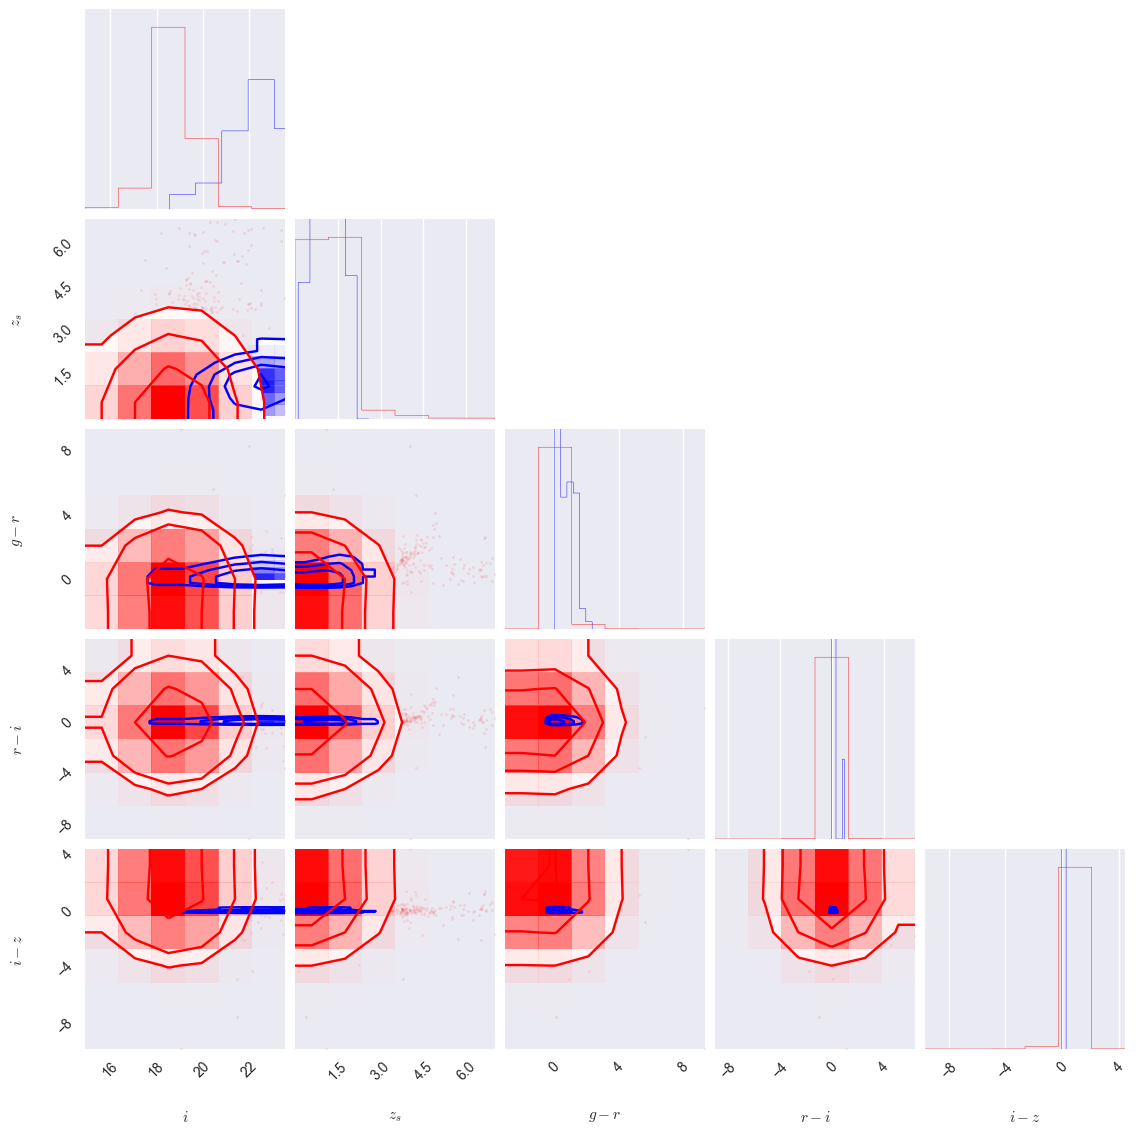

In [28]:
matplotlib.rc('text', usetex=False)
data = Table({'MAGI_Q': iReal, 'ZSRC': zReal, 'GR': grReal, 'RI': riReal, 'IZ': izReal}, names=['MAGI_Q', 'ZSRC', 'GR', 'RI', 'IZ'])
features, labels = plotting.extract_features(data, ('MAGI_Q','ZSRC', 'GR', 'RI', 'IZ'))
corner.corner(features, labels=labels, color='red', smooth=1.3, hist_kwargs=dict(normed=True), fig=fig1)

### Discussion